# Basic example cytometry workflow

Import the cytoflow module.

In [1]:
%matplotlib nbagg

import cytoflow as flow

The central data structure in `cytoflow` is the `Experiment`, which is basically a `pandas.DataFrame` containing the events; its associated metadata (experimental conditions and the like), and some methods to manipulate them.

You usually create an `Experiment` using an instance of the `ImportOp` class.  Start by defining two tubes, including their experimental conditions; then give those tubes, and a `dict` specifying the experimental conditions, to `ImportOp`.  Call the `apply()` function to get back the `Experiment` with all the data in it.

In [2]:
tube1 = flow.Tube(file = '../../cytoflow/tests/data/Plate01/RFP_Well_A3.fcs',
                  conditions = {"Dox" : 10.0})
tube2 = flow.Tube(file='../../cytoflow/tests/data/Plate01/CFP_Well_A4.fcs',
                  conditions = {"Dox" : 1.0})

import_op = flow.ImportOp(conditions = {"Dox" : "float"},
                          tubes = [tube1, tube2])

ex = import_op.apply()

Let's have a quick look at the experiment.  Instantiate a `HistogramView` and tell it which channel
we're looking at.  The `huefacet` trait says 'plot each `Dox` condition a different color on the same axes.'

<IPython.core.display.Javascript object>


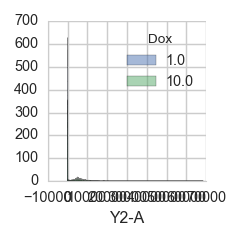

In [3]:
hist = flow.HistogramView()
hist.name = "Histogram view, by color"
hist.channel = 'Y2-A'
hist.huefacet = 'Dox'
hist.plot(ex)

Alternately, we could have the view plot the two conditions side-by-side.  CytoFlow's plotting takes inspiration from Trellis plots (eg the `lattice` package in R), where you tell the plotting module which metadata "facet" you want to plot in the X, Y and color (hue) axes.

This cell also demonstrates a different style of paramaterizing View and Operation instances, by passing trait values to the constructor.

<IPython.core.display.Javascript object>


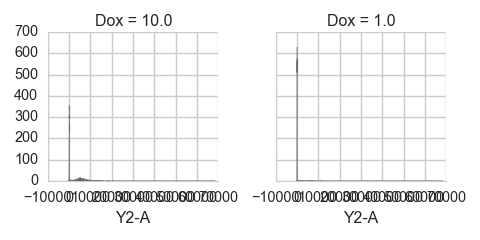

In [4]:
hist2 = flow.HistogramView(name = "Histogram view",
                           channel = "Y2-A",
                           xfacet = 'Dox')
hist2.plot(ex)

Because this is untransformed data, comparing these distributions is difficult.
Let's do a Logicle transformation to make them easier to visualize.

In [5]:
logicle = flow.LogicleTransformOp()
logicle.name = "Logicle transformation"
logicle.channels = ['V2-A', 'Y2-A', 'B1-A']
logicle.estimate(ex)
ex2 = logicle.apply(ex)

Note that an operation's `apply()` method takes an `Experiment` as a parameter and returns
an `Experiment`.  The latter is derived from the former; it maintains the same metadata, but with transformed data.  *The operation is not performed in place.*  This is the beginning of the **workflow** concept, which sees more full realization in the GUI.

Also note that both the semantics of the histogram view and the Logicle operation: they are parameterized separately from the `Experiment` they're operating on.  So, we can just reuse a pre-existing `HistogramView` instance to view the new `Experiment` instance that the logicle operation gave us.

<IPython.core.display.Javascript object>


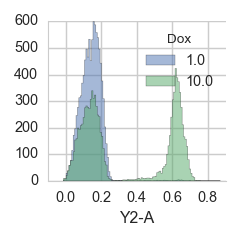

In [6]:
hist.plot(ex2)

Now we can see a clear difference between the two tubes: one has a large population > 0.3 in the Y2-A channel (transformed value), and the other tube doesn't.  Let's create a threshold gate to separate the populations.

In [7]:
thresh = flow.ThresholdOp()
thresh.name = "Y2-A+"
thresh.channel = 'Y2-A'
thresh.threshold = 0.3

ex3 = thresh.apply(ex2)

One more important semantic note.  A gate *does not remove events; it simply adds additional metadata to the events already there.*  You can get at an `Experiment`'s underlying `pandas.DataFrame` by looking at the `data` trait and verifying that all three `Experiments` we've created have the same number of events.

In [8]:
print ex.data.shape
print ex2.data.shape
print ex3.data.shape

(20000, 17)
(20000, 17)
(20000, 18)


The last experiment, though, has another column named 'Y2-A+', which is a column of `bool` values specifying whether each event ended up above the threshold or not.  Note the syntactic sugar that lets us access `Experiment` columns directly, without going through the `data` trait.

In [9]:
print ex3["Y2-A+"][0:10]

0    False
1     True
2    False
3    False
4    False
5    False
6     True
7    False
8     True
9    False
Name: Y2-A+, dtype: bool


Now we can plot using that additional piece of metadata as a factor. Again, these semantics are similar to Trellis (or Lattice) plots in R.

<IPython.core.display.Javascript object>


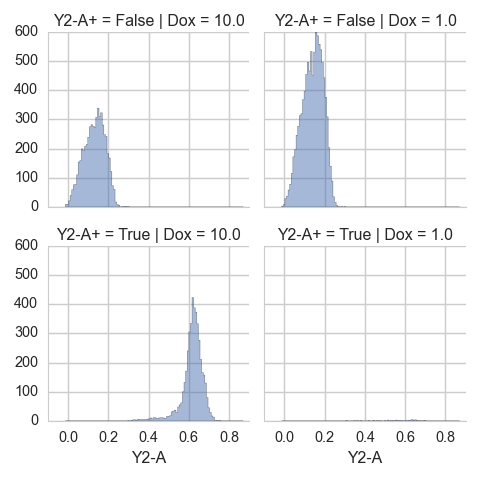

In [10]:
hist3 = flow.HistogramView()
hist3.name = "Histogram view, grid"
hist3.channel = 'Y2-A'
hist3.xfacet = 'Dox'
hist3.yfacet = 'Y2-A+'
hist3.plot(ex3)

....or we can ask "how many events were above the threshold?"  Because the underlying data is still available, we can use the pandas API to answer the question.

In [11]:
ex3.data.groupby(['Dox', 'Y2-A+']).size()

Dox  Y2-A+
1    False    9948
     True       52
10   False    5566
     True     4434
dtype: int64

There are also a basic set of statistics views (to be expanded later.) The same data in a bar chart:

<IPython.core.display.Javascript object>


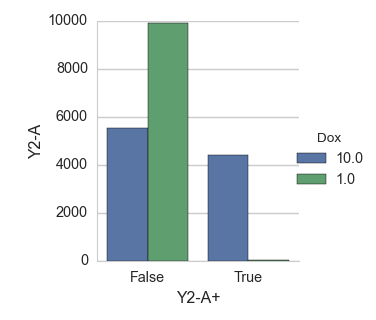

In [12]:
bar = flow.BarChartView()
bar.name = "Bar Chart"
bar.channel = 'Y2-A'
bar.variable = 'Y2-A+'
bar.huefacet = 'Dox'
bar.function = len

bar.plot(ex3)

Because `Dox` is a numeric variable, it may make more sense plotted with a line plot.

<IPython.core.display.Javascript object>


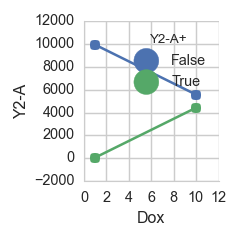

In [13]:
line = flow.Stats1DView()
line.name = "Line Plot"
line.variable = "Dox"
line.ychannel = "Y2-A"
line.yfunction = len
line.huefacet = "Y2-A+"

line.plot(ex3)

....or maybe not.  (-:  Just because something is *easy* to do doesn't make it the *right* thing to do.

I hope this makes the semantics of the cytoflow package clear.  I'm pretty married to them, because I think they support the right combination of ease of use for interactive work and power for scripting/integration into larger programs (like the accompanying GUI.)